In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from keras.models import model_from_json
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import custom_scores
import CMAPSAuxFunctions
from tunableModel import TunableModel

%matplotlib inline

C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
data = np.genfromtxt('scores_all_datasets3.csv', delimiter=',')
#print(data)

for i in range(4):
    tempScoresRMSE = data[i*3+0]
    tempScoresRHS = data[i*3+1]
    tempTime = data[i*3+2]
    
    print(stats.describe(tempScoresRMSE))
    print(stats.describe(tempScoresRHS))
    print(stats.describe(tempTime))

DescribeResult(nobs=10, minmax=(12.266621376727986, 13.837268516582309), mean=12.955242308582109, variance=0.27966302880455679, skewness=0.20201204255283464, kurtosis=-1.2133905294131517)
DescribeResult(nobs=10, minmax=(237.42350047694691, 352.26800567166515), mean=290.70948500870566, variance=1484.5444191967676, skewness=0.1493268836140663, kurtosis=-1.1701682292355864)
DescribeResult(nobs=10, minmax=(14.464465506329361, 15.57628529019712), mean=14.677520721363544, variance=0.10482436433738088, skewness=2.4308685042567246, kurtosis=4.374353316397398)
DescribeResult(nobs=10, minmax=(16.154418929978601, 18.182472785688876), mean=16.858005715354878, variance=0.48339603163934769, skewness=0.8632985045099908, kurtosis=-0.5784246248915061)
DescribeResult(nobs=10, minmax=(1522.3218525371171, 1910.0646263473964), mean=1732.3600226107628, variance=23120.18972954134, skewness=-0.13300756592597052, kurtosis=-1.5751868389702237)
DescribeResult(nobs=10, minmax=(37.773115328689528, 39.6380205209534

[ 15.25844029  15.15420734  15.04027925  14.95326051  14.90268432
  14.91341678  14.94289129  14.89093684  14.78343668  15.04194136]


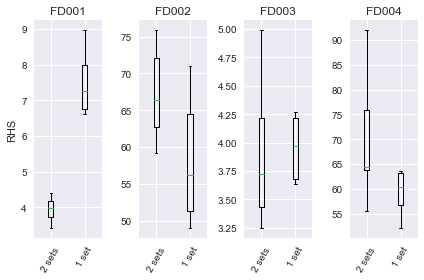

In [2]:
data = np.genfromtxt('results/scores_all_datasets.csv', delimiter=',')

data_rmse = [] 
data_rhs = []

print(data[0])

for dataset in range(4):
    
    #data_rmse.append([data[dataset*3], data[dataset*3+12], data[dataset*3+24]]) 
    #data_rhs.append([data[dataset*3+1], data[dataset*3+13], data[dataset*3+25]])
    
    data_rmse.append([data[dataset*3], data[dataset*3+12]]) 
    data_rhs.append([data[dataset*3+1], data[dataset*3+13]])


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f.suptitle('Different sets of data-related parameters')
plt_ax = [ax1, ax2, ax3, ax4]
count = 0

for data_plot in data_rmse:
    plt_ax[count].boxplot(data_plot, showfliers=False)
    plt.sca(plt_ax[count])
    locs, _ = plt.xticks()
    plt.xticks(locs, ['2 sets', '1 set'], rotation=60)
    if count == 0:
        plt_ax[count].set_ylabel('RMSE')
        
    plt_ax[count].set_title('FD00'+str(count+1))
    count = count + 1 

f.tight_layout()
plt.savefig('rmse_comparisson.svg', bbox_inches='tight', format='svg')
plt.savefig('rmse_comparisson.png', bbox_inches='tight')

plt.clf()
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f.suptitle('Different sets of data-related parameters')
plt_ax = [ax1, ax2, ax3, ax4]

count = 0
for data_plot in data_rhs:
    plt_ax[count].boxplot(data_plot, showfliers=False)
    plt.sca(plt_ax[count])
    locs, _ = plt.xticks()
    plt.xticks(locs, ['2 sets', '1 set'], rotation=60)
    if count == 0:
        plt_ax[count].set_ylabel('RHS')
        
    plt_ax[count].set_title('FD00'+str(count+1))
    count = count + 1 

f.tight_layout()
plt.savefig('rhs_comparisson.svg', bbox_inches='tight', format='svg')
plt.savefig('rhs_comparisson.png', bbox_inches='tight')


In [4]:
# load json and create model
json_file = open('bestRULModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("bestRULModel.h5")
print("Loaded model from disk")


#Shared parameters for the models
optimizer = Adam(lr=0, beta_1=0.5)
lossFunction = "mean_squared_error"
metrics = ["mse"]

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

windowSize = 20
stride = 1
constRUL = 100


dataFolder = '../CMAPSSData'

#Create and compile the models
#nFeatures = len(selected_features)
#shapeSN = nFeatures*windowSize
#modelRULSN = RULmodel_SN_1(shapeSN)
loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

tModel = TunableModel('Loaded_Model', loaded_model, selected_features, dataFolder, window_size=windowSize,
                      scaler = min_max_scaler, window_stride=stride, constRul = constRUL, lib_type='keras')
tModel.loadData(verbose=1)
tModel.getModelDescription()


Loaded model from disk
Loading data for dataset 1 with window_size of 20, stride of 1 and constRUL of 100. Cros-Validation ratio 0
Data loaded for dataset 1
Description for model: Loaded_Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 30)                6330      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 10)                310       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
out (Dense)                  (None, 1)                 11        
Total params: 6,651
Trainable params: 6,651
Non-trainable params: 0
_____________

In [5]:
# evaluate loaded model on test data
tModel.evaluateModel(["rhs"], round=2)
print("scores")

#print(tModel.y_pred)

cScores = tModel.scores
rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
rhs = cScores['rhs']
time = tModel.trainTime

i = 1
for prediction in tModel.y_pred:
    print('Engine {}, RUL {}, Rectified RUL {}, Real RUL {}'.format(i, prediction, 
                                                                    tModel.y_pred_rectified[i-1], 
                                                                    tModel.y_test[i-1]))
    i = i+1

print(cScores)
print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("RHS: {}".format(rhs))
print("Time : {} seconds".format(time))

ValueError: Error when checking input: expected fc1_input to have shape (None, 210) but got array with shape (100, 280)

In [12]:
def plotRUL(cycles, rulArray, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    
    plt.show()
    
def plotRUL_Engine(tModel, engineUnit):

    time_window = tModel.windowSize
    constRUL = tModel.constRul
    stride = tModel.windowStride
    selectedFeatures = tModel.selectedFeatures
    
    df = tModel.df_train
    df_engine = df.loc[df['Unit Number'] == engineUnit, :]
    df_engine['Unit Number'] = 1
    
    X_test2, _, _, _, _ = CMAPSAuxFunctions.create_windowed_data(df_engine, selected_features, 'train', time_window=time_window, 
                                                     constRUL=constRUL, stride=stride)
    
    X_test2 = tModel.dataScaler.transform(X_test2)
    #nnPred = tModel.model.predict(X_test2)
    
    maxCycle = X_test2.shape[0]
    faultCycle = tModel.y_test[engineUnit-1]
    cycles = np.arange(maxCycle)
    rulArray = np.arange(faultCycle, maxCycle+faultCycle)
    rulArray[rulArray > constRUL] = constRUL
    rulArray = np.flipud(rulArray)
    
    plotRUL(cycles, rulArray, engineUnit)
    #plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    #plt.legend()

C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Projects\NASA_RUL_-CMAPS-\code\CMAPSAuxFunctions.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RUL'] = df.apply(compute_training_RUL, axis = 1, args=(rul_vector,constRUL,))


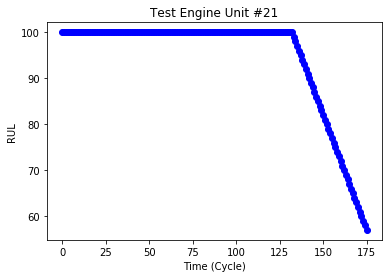

In [13]:
plotRUL_Engine(tModel, 21)

In [26]:
data = np.genfromtxt('intermediateResultsbruteforce_notRectified1.csv', delimiter=',')
rmse = data[:,3]
maxIndex = np.argmax(rmse)
minIndex = np.argmin(rmse)
print(data[maxIndex])
print(data[minIndex])

[  19.        9.       97.       80.9299 3221.0715]
[ 30.       1.     125.      17.4395   5.2236]


In [27]:
data = np.genfromtxt('intermediateResultsbruteforce_notRectified2.csv', delimiter=',')
rmse = data[:,3]
maxIndex = np.argmax(rmse)
minIndex = np.argmin(rmse)
print(data[maxIndex])
print(data[minIndex])

[1.90000000e+01 1.00000000e+01 1.09000000e+02 7.68065000e+01
 1.84485618e+04]
[ 20.       1.     135.      36.891  114.8625]
